In [1]:
import seaborn as sns
from main import preprocess

In [2]:
df, df_small, source = preprocess(0, 6)

In [3]:
df.iloc[0]

age               0.301370
workclass         0.625000
education-num     0.800000
capital-gain      0.021740
capital-loss      0.000000
hours-per-week    0.397959
50K               0.000000
Name: 0, dtype: float64

In [4]:
df_small.iloc[source]

age               0.333924
workclass         0.513062
education-num     0.675521
capital-gain      0.009708
capital-loss      0.008112
hours-per-week    0.416643
50K               0.000000
Name: 4, dtype: float64

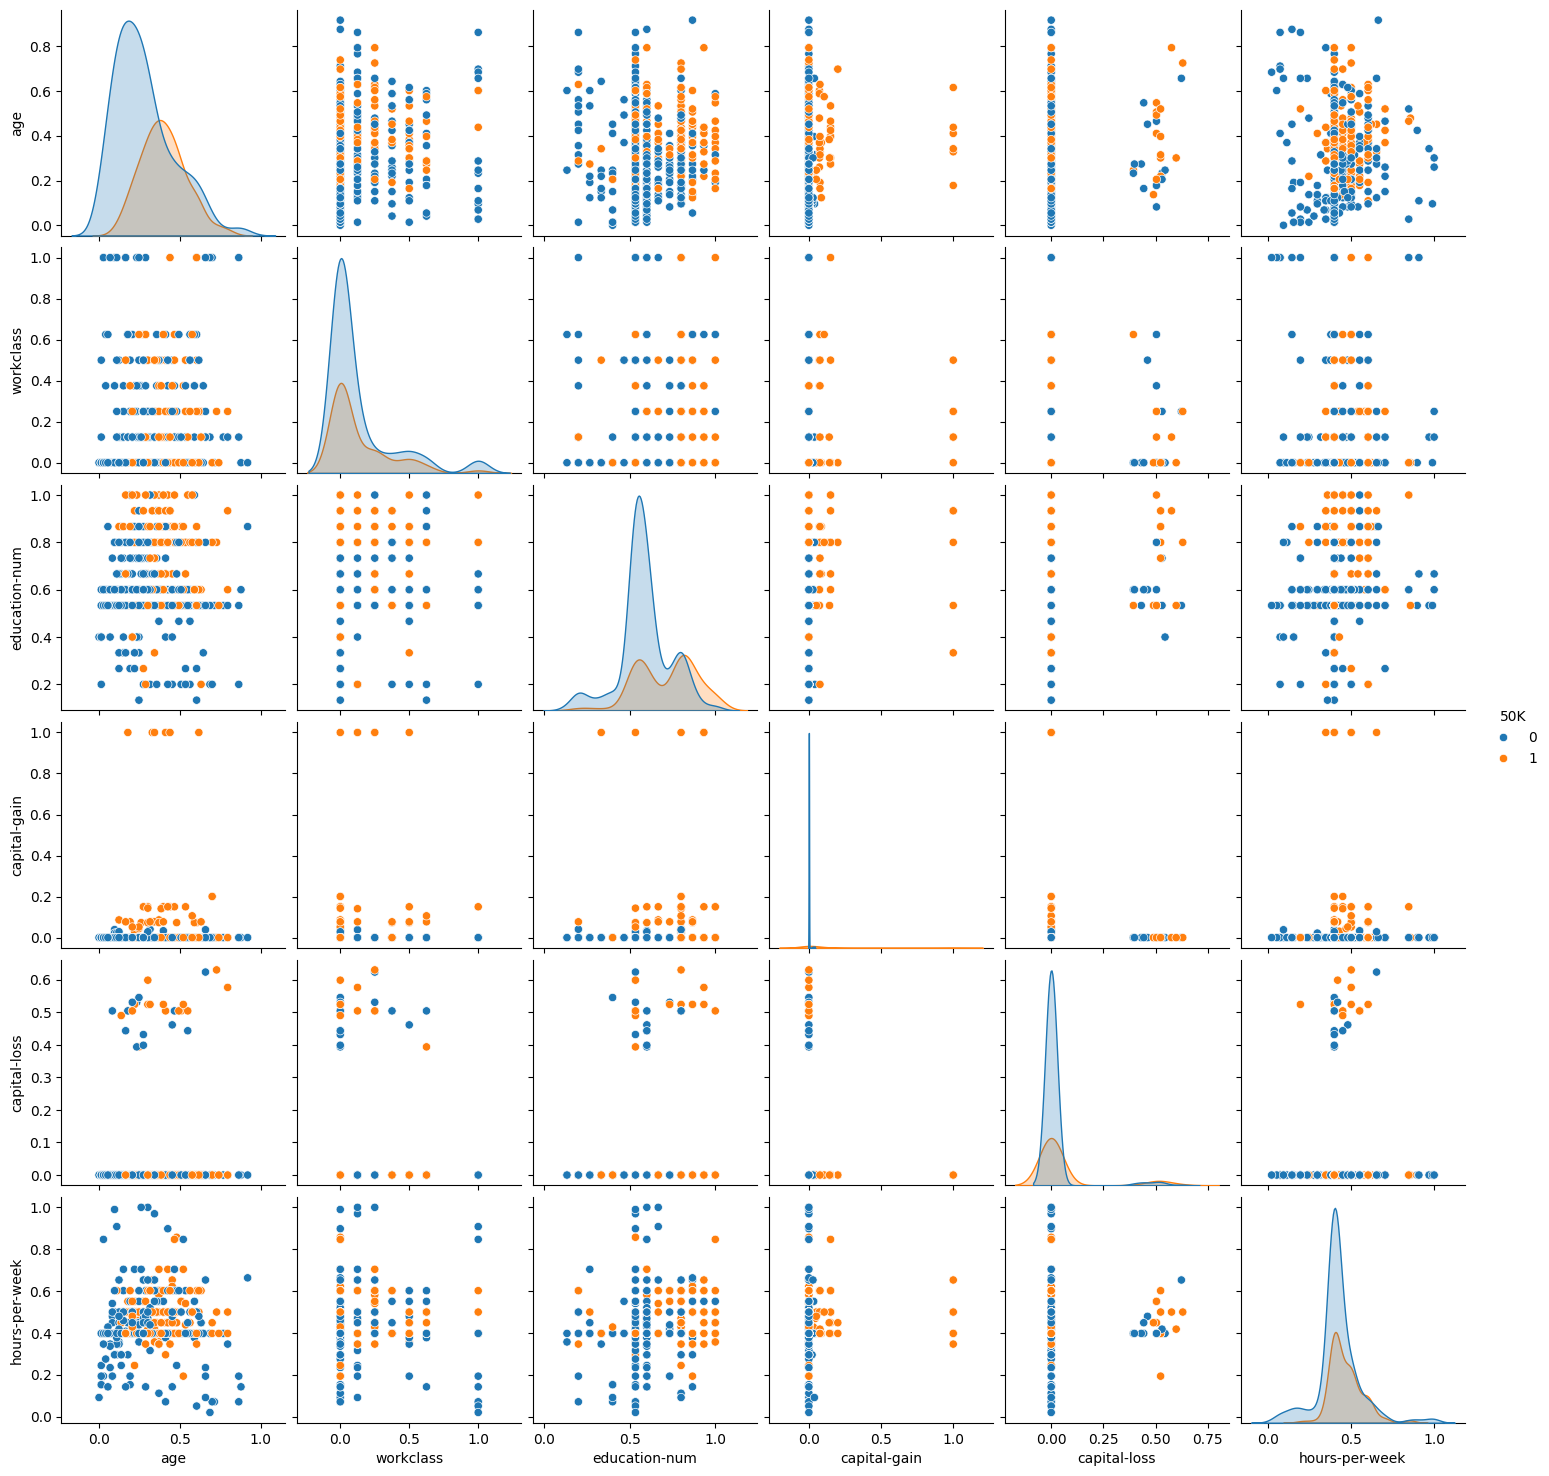

In [5]:
sns.pairplot(df.sample(512), hue="50K")

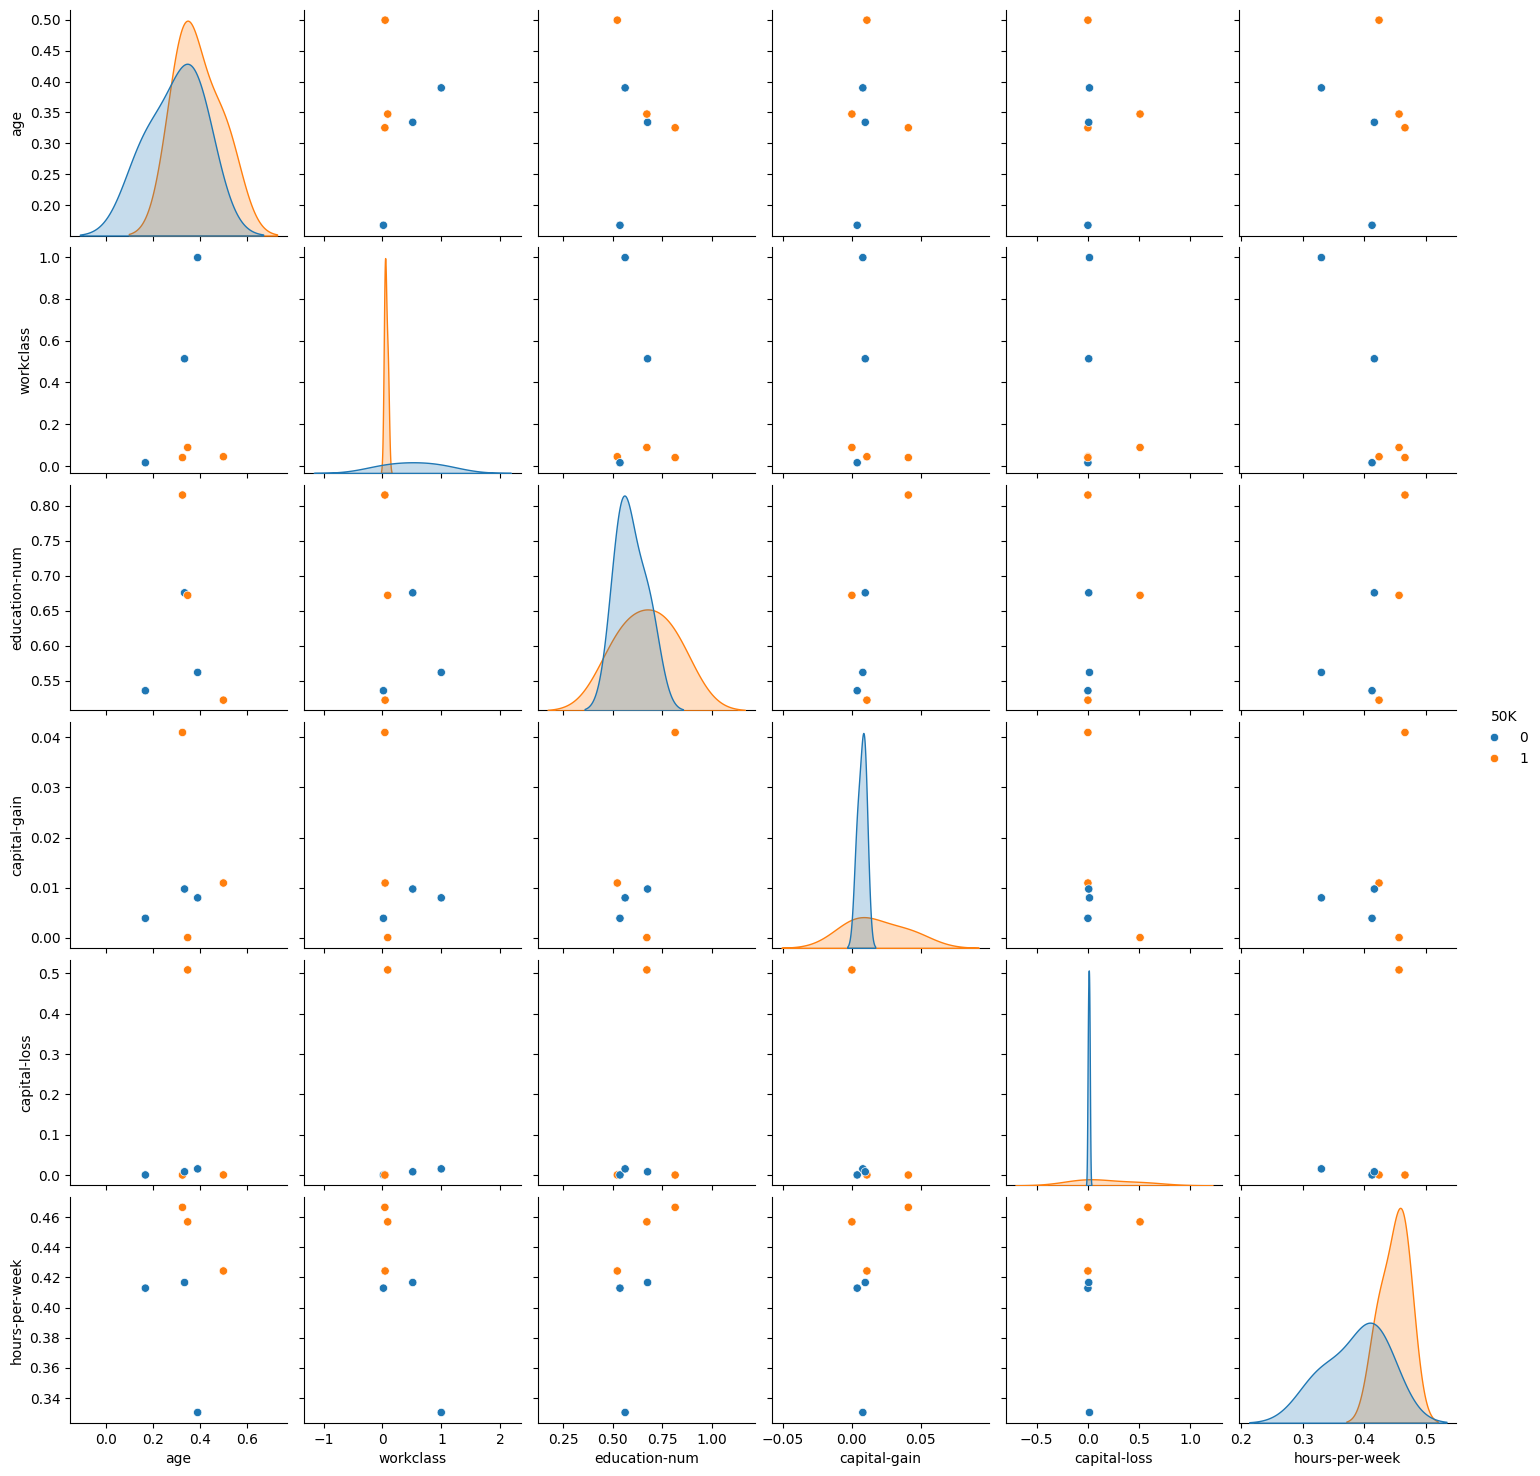

In [6]:
sns.pairplot(df_small, hue="50K")

In [7]:
df.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000
mean,0.312178,0.133901,0.617666,0.014086,0.027814,0.425856,0.325157
std,0.184411,0.256048,0.165146,0.086013,0.116493,0.125438,0.468447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164384,0.000000,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.287671,0.000000,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.438356,0.125000,0.800000,0.000000,0.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df_small.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000
mean,0.343768,0.283212,0.630453,1.223497e-02,0.088799,0.417944,0.500000
std,0.107765,0.396800,0.112333,1.465338e-02,0.205806,0.048177,0.547723
min,0.167025,0.015838,0.522422,-9.887924e-17,0.000045,0.330414,0.000000
25%,0.327303,0.041402,0.542427,4.875656e-03,0.000281,0.413840,0.000000
50%,0.340610,0.066631,0.616951,8.826964e-03,0.004218,0.420471,0.500000
75%,0.379139,0.406969,0.674619,1.060893e-02,0.013526,0.448740,1.000000
max,0.499512,0.996767,0.814968,4.099440e-02,0.508714,0.466517,1.000000


In [11]:
from algo import recourse


In [10]:
recourse(df_small, 2, source, limit=100000)

[[(0.1655877366101115, 0.2538196828586726)],
 [(0.0, 0.23470212650672204)],
 [(0.4837057179418086, 0.8473701896446251)],
 [(0.13944729172124548, 0.2807686489878903)],
 [(0.0, 0.0)],
 [(0.013371028018976105, -0.2486382801088875)]]